# CSI - Cannabis Strain Investigation

### Problem Statement

**Can a cannabis plant be classified as hybrid, sativa or indica based on effects, flavors and a description**

I don't expect the model to be perfect but I am hoping to obtain an accuracy of ~70% on classifying the correct plant type. 
I'm going to start with EDA, possible feature engineering, and then into supervised learning models. 

# Table of Contents
1.0 [Cleaning and EDA](#eda)

   
1.1 [Column Exploration](#columns)     
    
  
2.0 [Modelling](#models)

2.1 [Preprocessing](#preprocess)

2.2 [NLP - CountVectorizer on Description](#nlp CV )
    
2.2.1 [SKLearn Supervised Learning](#logreg,knn, svc, dt)
    
2.3 [NLP - TDIF-Vectorizer on Description](#nlp tdif)

2.3.1 [SKLearn Supervised Learning]

### Data Exploration
<a id='eda'></a>

We'll import our tools then load our datafile in as a dataframe.

In [3]:
# load some tools
import pandas as pd
import numpy as np
import seaborn as sns
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# read in the datafile
weed_df = pd.read_csv('datafiles/cannabis.csv')

#### Inspect the data

Check out:
1. Shape
2. Null Values
3. Duplicate Rows
4. Datatypes

In [5]:
# check out the shape
weed_df.shape

(2351, 6)

We have 6 features and 2351 entries. We'll have to check for duplicates, missing values and any other issues that could exist within the data.

In [6]:
# check for null values
weed_df.isna().sum()

Strain          0
Type            0
Rating          0
Effects         0
Flavor         46
Description    33
dtype: int64

We're missing some flavor and description values for some strains. When looking at the data for our missing flavor/description values, we can see that missing effects values have the value 'None' listed in that column. I'll fill the missing flavor/descriptions also with 'None' to keep the datatypes as strings. I also don't want to drop those rows since they still still have some information.

In [7]:
# fill NaNs will the string 'none'
weed_df.fillna('None', inplace=True)

In [8]:
# check again for nulls
weed_df.isna().sum()

Strain         0
Type           0
Rating         0
Effects        0
Flavor         0
Description    0
dtype: int64

In [9]:
weed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351 entries, 0 to 2350
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Strain       2351 non-null   object 
 1   Type         2351 non-null   object 
 2   Rating       2351 non-null   float64
 3   Effects      2351 non-null   object 
 4   Flavor       2351 non-null   object 
 5   Description  2351 non-null   object 
dtypes: float64(1), object(5)
memory usage: 110.3+ KB


In [10]:
weed_df.describe()

,Rating
count,2351.000000
mean,4.310634
std,0.836394
min,0.000000
25%,4.200000
50%,4.400000
75%,4.700000
max,5.000000


In [11]:
# check for duplicates
weed_df.loc[weed_df.duplicated()]

,Strain,Type,Rating,Effects,Flavor,Description
151,B-Witched,hybrid,5.0,"Euphoric,Relaxed,Happy,Hungry,Sleepy","Earthy,Sweet,Citrus",B-Witched by Ocean Grown Seeds is a magical cr...


In [12]:
# we have one duplicate entry called 'B-Witched', we'll drop the extra row.
weed_df.drop_duplicates(inplace=True)

# double check for duplicates.
weed_df.duplicated().sum()

0

I have addressed both missing values and duplicate entries. Now, we'll start doing some visual exploration of our data to see what trends or patterns exist.

## Individual Column Analysis
<a id='columns'></a>

### Plant Type (Target Variable)

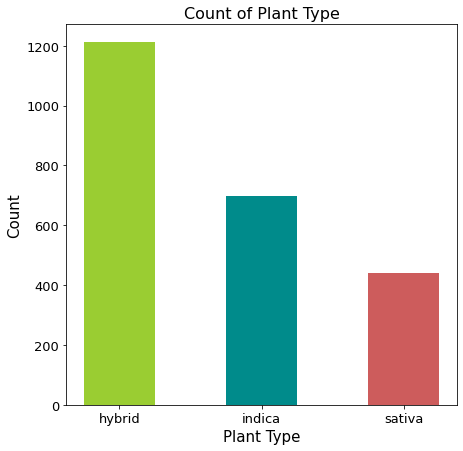

In [13]:
# distribution of plant type
# set up x and y for graph
x = weed_df['Type'].value_counts().index.tolist()
y = weed_df['Type'].value_counts()

# create color palette
colors = ['yellowgreen', 'darkcyan', 'indianred']

# plot figure
plt.figure(figsize=(7,7))
plt.bar(x, y, color=colors, width=0.5)

# add labels and set axis
# x-axis
plt.xlabel('Plant Type', size=15)
plt.xticks(size=13)

plt.ylabel('Count', size=15)
plt.yticks(size=13)
           
plt.title('Count of Plant Type', size=16)
plt.show()

Let's also check out the distribution in terms of the total.

In [14]:
print("Hybrids: ", round(len(weed_df.loc[weed_df['Type']=='hybrid']) / len(weed_df),3)*100,"%")
print("Sativas: ", round(len(weed_df.loc[weed_df['Type']=='sativa']) / len(weed_df),3)*100,"%")
print("Indicas: ", round(len(weed_df.loc[weed_df['Type']=='indica']) / len(weed_df),3)*100,"%")

Hybrids:  51.5 %
Sativas:  18.7 %
Indicas:  29.7 %


#### Analysis - Plant Type

We can see that half of our values are Hybrid strains, with the other half being split 30/20 indica and sativa respectively. I'll have to keep the class distribution in mind when performing modeling, I can consider doing some upsampling or downsamplking to help make the classes more balanced.

Let's explore our other columns.

## Ratings Column

In [15]:
# Explore average, max, min, and median ratings
print("Average Rating: ", round(weed_df['Rating'].mean(), 3))
print("Max Rating: ", weed_df['Rating'].max())
print("Min Rating: ", weed_df['Rating'].min())
print("Median Rating: ", weed_df['Rating'].median())

Average Rating:  4.31
Max Rating:  5.0
Min Rating:  0.0
Median Rating:  4.4


In [16]:
# average rating for each type
print("Average Rating by Plant Type: ", weed_df.groupby('Type').mean()['Rating'])

Average Rating by Plant Type:  Type
hybrid    4.291082
indica    4.347783
sativa    4.303864
Name: Rating, dtype: float64


In [17]:
# check out rating distribtuion for each type 
pd.crosstab(weed_df['Rating'], weed_df['Type']).transpose()

Rating,0.0,1.0,2.0,2.5,2.8,3.0,3.1,3.2,3.3,3.4,...,4.1,4.2,4.3,4.4,4.5,4.6,4.7,4.8,4.9,5.0
Type,,,,,,,,,,,,,,,,,,,,,
hybrid,42,1,1,1,0,6,1,1,2,2,...,56,113,150,144,164,114,95,88,31,101
indica,16,0,1,0,0,4,0,2,0,1,...,33,64,89,83,94,78,47,41,19,70
sativa,13,0,0,0,1,3,0,0,1,2,...,12,48,58,57,59,50,22,30,9,38


In [18]:
#  rating distribution for ratings =3.5
pd.crosstab(weed_df[weed_df['Rating'] >= 3.5]['Rating'], weed_df['Type']).transpose()

Rating,3.5,3.6,3.7,3.8,3.9,4.0,4.1,4.2,4.3,4.4,4.5,4.6,4.7,4.8,4.9,5.0
Type,,,,,,,,,,,,,,,,
hybrid,5,6,7,9,9,62,56,113,150,144,164,114,95,88,31,101
indica,2,4,5,10,12,24,33,64,89,83,94,78,47,41,19,70
sativa,2,1,4,4,8,18,12,48,58,57,59,50,22,30,9,38


We can see above in the crosstab result that there are a few strains with a rating of 0, with the majority of ratings >= 4.0. Let's visually take a look at each strain type and its respective ratings.

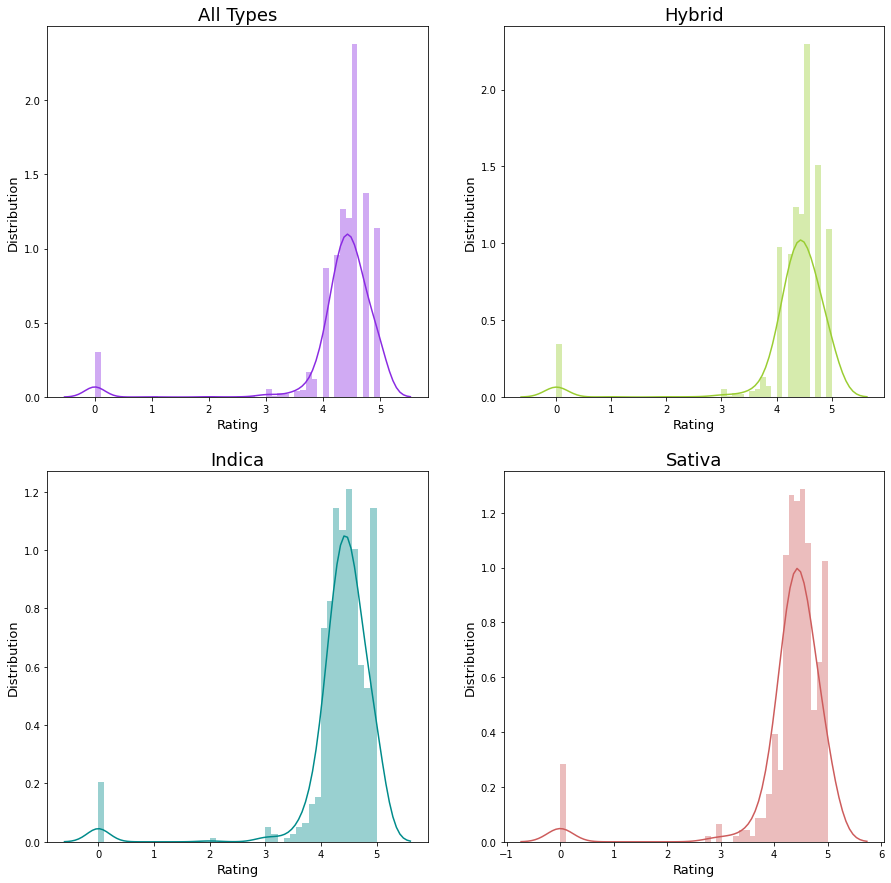

In [19]:
# distribution plot of ratings
# create 2x2 subplot
plt.subplots(2,2, figsize=(15,15),sharex=True, sharey=True, squeeze=True)

# plot distribution of all plant types
plt.subplot(2,2,1)
sns.distplot(weed_df['Rating'], color='blueviolet')
# labels and title
plt.xlabel('Rating', fontsize=13)
plt.ylabel('Distribution', fontsize=13)
plt.title('All Types', fontsize=18)

# plot of just hybrid
plt.subplot(2,2,2)
sns.distplot(weed_df[(weed_df['Type'] == 'hybrid')]['Rating'], color='yellowgreen')
# labels and title
plt.xlabel('Rating', fontsize=13)
plt.ylabel('Distribution', fontsize=13)
plt.title('Hybrid', fontsize=18)

# plot of just indica
plt.subplot(2,2,3)
sns.distplot(weed_df[(weed_df['Type'] == 'indica')]['Rating'], color='darkcyan')
# labels and title
plt.xlabel('Rating', fontsize=13)
plt.ylabel('Distribution', fontsize=13)
plt.title('Indica', fontsize=18)

# plot of just sativa
plt.subplot(2,2,4)
sns.distplot(weed_df[(weed_df['Type'] == 'sativa')]['Rating'], color='indianred')
# labels and title
plt.xlabel('Rating', fontsize=13)
plt.ylabel('Distribution', fontsize=13)
plt.title('Sativa', fontsize=18)

# display plots
plt.show()

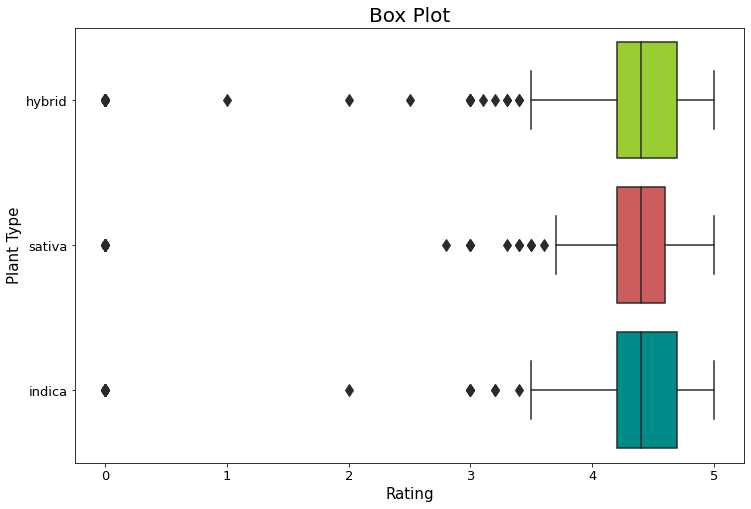

In [20]:
# box plot of ratings across types
# set up color palette
colors=['yellowgreen', 'indianred', 'darkcyan']

# create figure
plt.figure(figsize=(12,8))

# create boxplot
sns.boxplot(x='Rating',
            y='Type',
            data=weed_df,
            palette=colors,
            fliersize=9,
            whis=1.5,
            saturation=1.0)

# set title and labels
plt.title('Box Plot', fontsize=20)
plt.xticks(fontsize=13)
plt.xlabel('Rating', fontsize=15)
plt.yticks(fontsize=13)
plt.ylabel('Plant Type', fontsize=15)
plt.show()

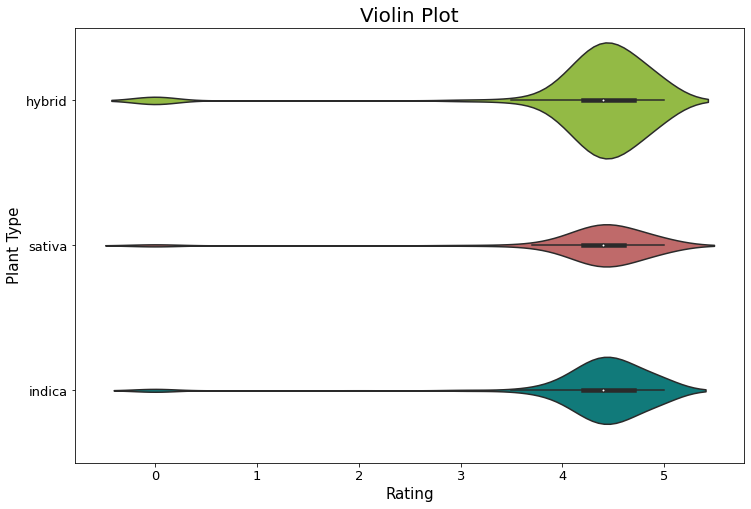

In [21]:
# violin plot of ratings across types

# create figure
plt.figure(figsize=(12,8))

# create violinplot
sns.violinplot(x='Rating',
               y='Type',
               data=weed_df,
               palette=colors,
               scale="count")

# set title and labels
plt.title('Violin Plot', fontsize=20)
plt.xlabel('Rating', fontsize=15)
plt.ylabel('Plant Type', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

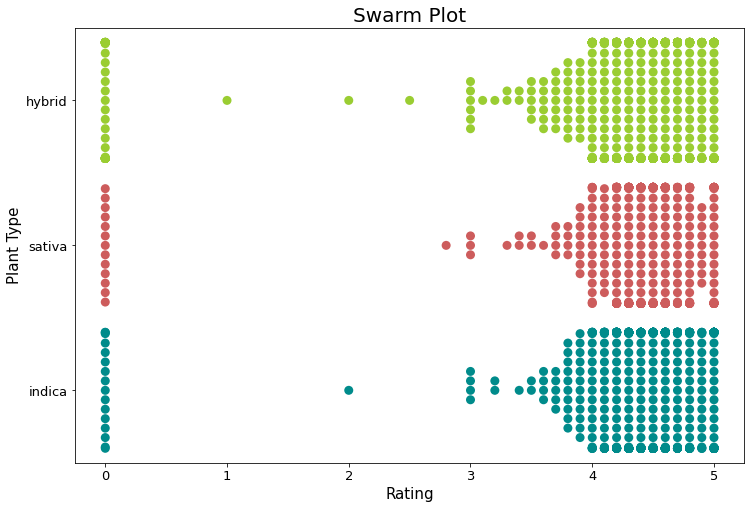

In [22]:
# swarmplot of rating across types
plt.figure(figsize=(12,8))

# create swarmplot
sns.swarmplot(x='Rating',
              y='Type',
              data=weed_df,
              palette=colors,
              size=9)

# set title and labels
plt.title('Swarm Plot', fontsize=20)
plt.xlabel('Rating', fontsize=15)
plt.ylabel('Plant Type', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

#### Analysis - Ratings

For the most part the ratings look to be similarily distributed across all three strains. Looks like Hybrids have received more lower scores compared to Sativa/Indica but this could be because there are more hybrid strains in the dataset leading to a higher probability of receiving a lower score due to CLT. 

Our average rating for each plant type is about 4.4 / 5.0.

## Effects & Flavors Columns

#### Effects

I want to explore the different effects listed for each strain. I'm going to split the list in each row and store the words into new columns named by the effect number.

In [23]:
# Create effects dataframe 
effects_df = pd.DataFrame(weed_df['Effects'].str.split(',').tolist(),\
                          columns = ['Effect 1', 'Effect 2', 'Effect 3', 'Effect 4', 'Effect 5'])

In [24]:
# check
effects_df.head()

,Effect 1,Effect 2,Effect 3,Effect 4,Effect 5
0,Creative,Energetic,Tingly,Euphoric,Relaxed
1,Relaxed,Aroused,Creative,Happy,Energetic
2,Uplifted,Happy,Relaxed,Energetic,Creative
3,Tingly,Creative,Hungry,Relaxed,Uplifted
4,Happy,Relaxed,Euphoric,Uplifted,Talkative


In [25]:
# append our effects_df to our weed_df
weed_df = weed_df.merge(effects_df, how='left', left_index=True, right_index=True).drop(columns={'Effects'})

In [26]:
# check
weed_df.head()

,Strain,Type,Rating,Flavor,Description,Effect 1,Effect 2,Effect 3,Effect 4,Effect 5
0,100-Og,hybrid,4.0,"Earthy,Sweet,Citrus",$100 OG is a 50/50 hybrid strain that packs a ...,Creative,Energetic,Tingly,Euphoric,Relaxed
1,98-White-Widow,hybrid,4.7,"Flowery,Violet,Diesel",The ‘98 Aloha White Widow is an especially pot...,Relaxed,Aroused,Creative,Happy,Energetic
2,1024,sativa,4.4,"Spicy/Herbal,Sage,Woody",1024 is a sativa-dominant hybrid bred in Spain...,Uplifted,Happy,Relaxed,Energetic,Creative
3,13-Dawgs,hybrid,4.2,"Apricot,Citrus,Grapefruit",13 Dawgs is a hybrid of G13 and Chemdawg genet...,Tingly,Creative,Hungry,Relaxed,Uplifted
4,24K-Gold,hybrid,4.6,"Citrus,Earthy,Orange","Also known as Kosher Tangie, 24k Gold is a 60%...",Happy,Relaxed,Euphoric,Uplifted,Talkative


#### Flavors

I'm going to repeat the same process for Flavors as I did for Effects - split the values in each row into a list then create a new column for each flavor in the list. 

We can append this flavor_df to our weed_df afterwards.

In [27]:
weed_df['Flavor'] = weed_df['Flavor'].astype(str)

In [28]:
flavor_df = pd.DataFrame(weed_df['Flavor'].str.split(',').tolist(),\
                         columns = ['Flavor 1', 'Flavor 2', 'Flavor 3', 'Flavor 4'])
flavor_df.head()

,Flavor 1,Flavor 2,Flavor 3,Flavor 4
0,Earthy,Sweet,Citrus,None
1,Flowery,Violet,Diesel,None
2,Spicy/Herbal,Sage,Woody,None
3,Apricot,Citrus,Grapefruit,None
4,Citrus,Earthy,Orange,None


In [29]:
# append our effects_df to our weed_df
weed_df = weed_df.merge(flavor_df, how='left', left_index=True, right_index=True).drop(columns={'Flavor'})

In [30]:
# check our result
weed_df.isna().sum()

Strain            0
Type              0
Rating            0
Description       0
Effect 1          1
Effect 2         98
Effect 3        113
Effect 4        140
Effect 5        172
Flavor 1          1
Flavor 2        191
Flavor 3        235
Flavor 4       2307
dtype: int64

Since I split our effects and flavor into separate columns we are bound to have some missing values as not every strain will have the same number of effects or flavors. As we can see above, I do have some NaN values to deal with. 

I'll fill these with the string value "None" to keep things consistent. 

In [31]:
# replace all NaNs with 'None'
weed_df.fillna('None', inplace=True)

In [32]:
# check
weed_df.isna().sum()

Strain         0
Type           0
Rating         0
Description    0
Effect 1       0
Effect 2       0
Effect 3       0
Effect 4       0
Effect 5       0
Flavor 1       0
Flavor 2       0
Flavor 3       0
Flavor 4       0
dtype: int64

In [33]:
# check out the dataframe
weed_df.head()

,Strain,Type,Rating,Description,Effect 1,Effect 2,Effect 3,Effect 4,Effect 5,Flavor 1,Flavor 2,Flavor 3,Flavor 4
0,100-Og,hybrid,4.0,$100 OG is a 50/50 hybrid strain that packs a ...,Creative,Energetic,Tingly,Euphoric,Relaxed,Earthy,Sweet,Citrus,None
1,98-White-Widow,hybrid,4.7,The ‘98 Aloha White Widow is an especially pot...,Relaxed,Aroused,Creative,Happy,Energetic,Flowery,Violet,Diesel,None
2,1024,sativa,4.4,1024 is a sativa-dominant hybrid bred in Spain...,Uplifted,Happy,Relaxed,Energetic,Creative,Spicy/Herbal,Sage,Woody,None
3,13-Dawgs,hybrid,4.2,13 Dawgs is a hybrid of G13 and Chemdawg genet...,Tingly,Creative,Hungry,Relaxed,Uplifted,Apricot,Citrus,Grapefruit,None
4,24K-Gold,hybrid,4.6,"Also known as Kosher Tangie, 24k Gold is a 60%...",Happy,Relaxed,Euphoric,Uplifted,Talkative,Citrus,Earthy,Orange,None


Now we have a workable dataframe so we can look at the distribution of effects and flavors.

Creating word clouds for effects, flavors, effects & flavors and descriptions. 

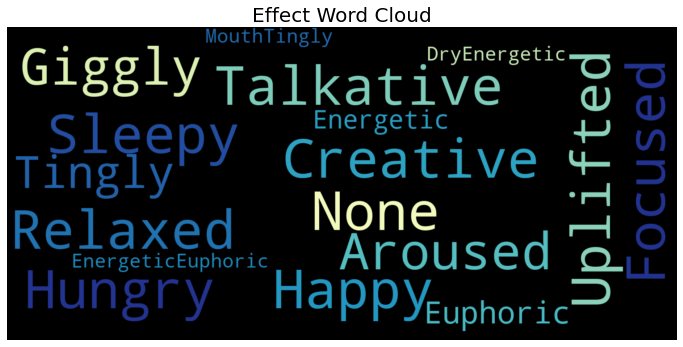

In [97]:
text1 = " ".join(weed_df['Effect 1'].unique())
text2 = " ".join(weed_df['Effect 2'].unique())
text3 = " ".join(weed_df['Effect 3'].unique())
text4 = " ".join(weed_df['Effect 4'].unique())

text = (text1 + text2 + text3 + text4)

stopwords = set(STOPWORDS)
stopwords.update(["None","none"])

# create word cloud for effects words
wordcloud = WordCloud(width=1500,
                      height=700,
                      stopwords=stopwords,
                      colormap='YlGnBu',
                      relative_scaling=0.5,
                      max_font_size=120).generate(text)

# Display the generated image:
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Effect Word Cloud", fontsize=20)
plt.axis("off")
plt.show()

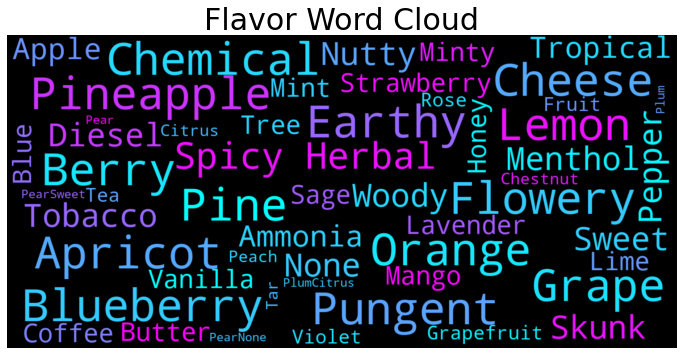

In [96]:
# Create and generate a word cloud image for flavors:
text5 = " ".join(weed_df['Flavor 1'].unique())
text6 = " ".join(weed_df['Flavor 2'].unique())
text7 = " ".join(weed_df['Flavor 3'].unique())
text8 = " ".join(weed_df['Flavor 4'].unique())

text_0 = (text5 + text6 + text7 + text8)

stopwords = set(STOPWORDS)
stopwords.update(['None','none'])

wordcloud = WordCloud(width=1500,
                      height=700,
                      stopwords=stopwords,
                      relative_scaling=0.5,
                      colormap='cool',
                      max_font_size=100).generate(text_0)

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Flavor Word Cloud", fontsize=30)
plt.show()

In [93]:
# effect and flavor word cloud. 
both_texts = sttext + text_0

TypeError: unsupported operand type(s) for +: 'module' and 'str'

In [92]:
stopwords = set(STOPWORDS)
stopwords.update(['None','none'])

wordcloud = WordCloud(
                      width=1500, 
                      height=700,
                      stopwords=stopwords, 
                      relative_scaling=0.5,
                      colormap='winter', 
                      max_font_size=100).generate(both_texts)

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Flavor & Effect Word Cloud", fontsize=30)
plt.show()

TypeError: unsupported operand type(s) for +: 'module' and 'str'

#### Description

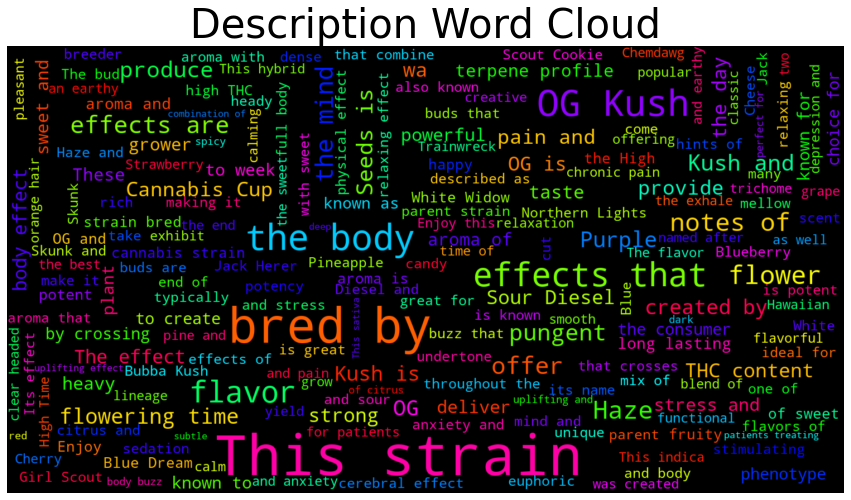

In [91]:
# Start with one review:
desc_text = " ".join(weed_df['Description'])

# Create and generate a word cloud image:
stopwords = set(STOPWORDS)
stopwords.update(["this", "the", "an", "sativa", "strain", 'indica', 'hybrid', 'This',\
                  'dominant', 'genetic', 'is', 'a', 'to','that', "This strain", 'by',\
                  'between', 'cross', 'and', 'it'])


wordcloud = WordCloud(
                      width=1500,
                      height=800, 
                      stopwords=stopwords, 
                      relative_scaling=1,
                      colormap='hsv', 
                      min_font_size=8,
                      max_font_size=100).generate(desc_text)

plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Description Word Cloud", fontsize=40)
plt.show()

Super cool! Let's do some analysis on each plant type and the effects, flavors and ratings for those strains. First I need to create a separate dataframe for each plant type. 

### Top Effects

In [38]:
ct_e1 = pd.crosstab(weed_df['Type'], weed_df['Effect 1'])
ct_e2 = pd.crosstab(weed_df['Type'], weed_df['Effect 2'])
ct_e3 = pd.crosstab(weed_df['Type'], weed_df['Effect 3'])
ct_e4 = pd.crosstab(weed_df['Type'], weed_df['Effect 4'])

In [39]:
effects_type_df = pd.concat([ct_e1, ct_e2, ct_e3, ct_e4], axis=0,\
                             ignore_index=False,\
                             keys=['1','2','3','4'],\
                             names=['Effect', 'Plant Type'])
effects_type_df.head()

Aroused  Creative  Dry  Energetic  Euphoric  Focused  \
Effect Plant Type                                                         
1      hybrid           28        49  0.0         41       126       25   
       indica            6        16  1.0         13        75       11   
       sativa            4        15  0.0         20        47       17   
2      hybrid            8        54  NaN         50       185       43   
       indica           10        36  NaN         29        96       24   

                   Giggly  Happy  Hungry  None  Relaxed  Sleepy  Talkative  \
Effect Plant Type                                                            
1      hybrid           5    230      13    43      427      39         35   
       indica           7    130      15    26      279      35         16   
       sativa           0    116       8    19      119      14          4   
2      hybrid          11    292      24    48      174      98         21   
       indica          12    177       7    29      106      71          5   

                   Tingly  Uplifted  Mouth  
Effect Plant Type                           
1      hybrid          22       128    NaN  
       indica           5        64    NaN  
       sativa           5        52    NaN  
2      hybrid          23       180    0.0  
       indica          12        84    1.0

In [40]:
effects_total = effects_type_df.groupby('Effect').sum().sum().sort_values(ascending=True).tail(10)

In [41]:
effects_total.drop('None', inplace=True)

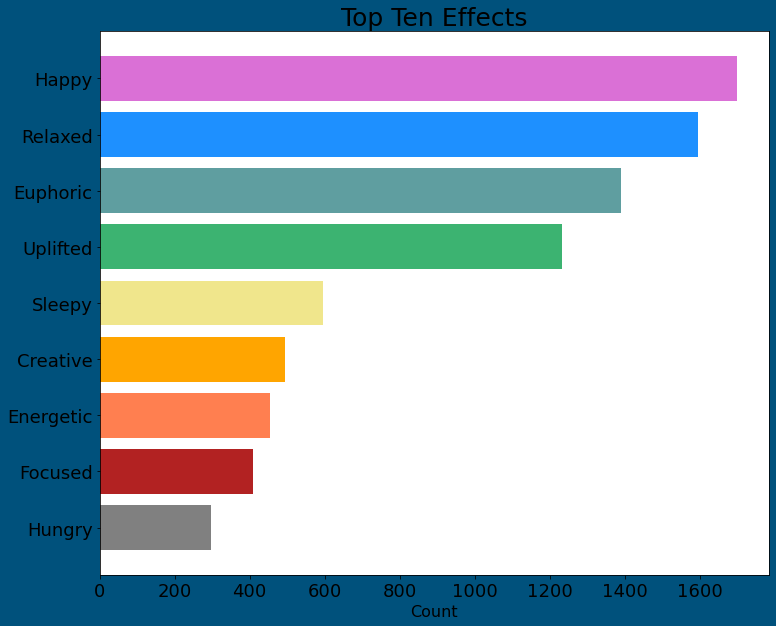

In [42]:
x = effects_total.index.to_list()
y = effects_total.values

# plot the effects. 
colors = ['grey','firebrick','coral', 'orange','khaki','mediumseagreen', 'cadetblue', 'dodgerblue', 'orchid', 'crimson']
plt.figure(figsize=(12,10),facecolor='#00517cff')
plt.barh(x, y, color=colors)
plt.yticks(fontsize=18)
plt.xlabel('Count', fontsize=16)
plt.xticks( fontsize=18)
plt.title('Top Ten Effects', fontsize=25)
plt.show()

#### Analysis of Effects
Our top effects are: 

    1. Happy
    2. Relaxed
    3. Euphorimc
    4. Uplifted
    
These four effects account the majority of effects listed in each strian. This is not surprising as the idea of cannabis is to provide relaxation and relief from pain and/or stress. 

In [43]:
effects_type_df.groupby('Plant Type').sum()

,Aroused,Creative,Dry,Energetic,Euphoric,Focused,Giggly,Happy,Hungry,None,Relaxed,Sleepy,Talkative,Tingly,Uplifted,Mouth
Plant Type,,,,,,,,,,,,,,,,
hybrid,72,270,0.0,242,718,209,86,865,153,214,820,285,136,117,657,0.0
indica,36,123,1.0,109,413,114,67,514,87,132,503,220,68,74,334,1.0
sativa,28,100,0.0,102,258,86,36,320,56,93,270,89,44,36,242,0.0


### Top Flavors

In [44]:
ct_f1 = pd.crosstab(weed_df['Type'], weed_df['Flavor 1'])
ct_f2 = pd.crosstab(weed_df['Type'], weed_df['Flavor 2'])
ct_f3 = pd.crosstab(weed_df['Type'], weed_df['Flavor 3'])

In [45]:
flavors_type_df = pd.concat([ct_f1, ct_f2, ct_f3], axis=0, ignore_index=False, keys=['1','2','3'],\
                           names=['Flavor', 'Plant Type'])

In [46]:
flavors_type_df.head()

Ammonia  Apple  Apricot  Berry  Blue  Blueberry  Butter  \
Flavor Plant Type                                                            
1      hybrid            9      4        1     70     2         41       5   
       indica            0      1        0     31     1         19       3   
       sativa            2      1        2     23     0          6       1   
2      hybrid            3      2        2     69     1         25       1   
       indica            3      2        1     36     0          7       0   

                   Cheese  Chemical  Citrus  ...  Tar  Tea  Tobacco  Tree  \
Flavor Plant Type                            ...                            
1      hybrid          12         1     102  ...  3.0    1        1     3   
       indica           8         4      51  ...  0.0    0        1     3   
       sativa           4         0      35  ...  0.0    0        0     0   
2      hybrid           7         6     117  ...  NaN    2        1     3   
       indica           5         7      43  ...  NaN    2        0     6   

                   Tropical  Vanilla  Violet  Woody  Chestnut  Fruit  
Flavor Plant Type                                                     
1      hybrid            17        2       1     19       NaN    NaN  
       indica            12        1       1      9       NaN    NaN  
       sativa            11        0       0      3       NaN    NaN  
2      hybrid            22        7       1     59       0.0    3.0  
       indica            11        4       1     32       1.0    3.0  

[5 rows x 50 columns]

In [47]:
flavors_total = flavors_type_df.groupby('Flavor').sum().sum().sort_values(ascending=True).tail(10)

In [48]:
flavors_total = flavors_total.drop('None')

In [49]:
x = flavors_total.index.to_list()
y = flavors_total.values

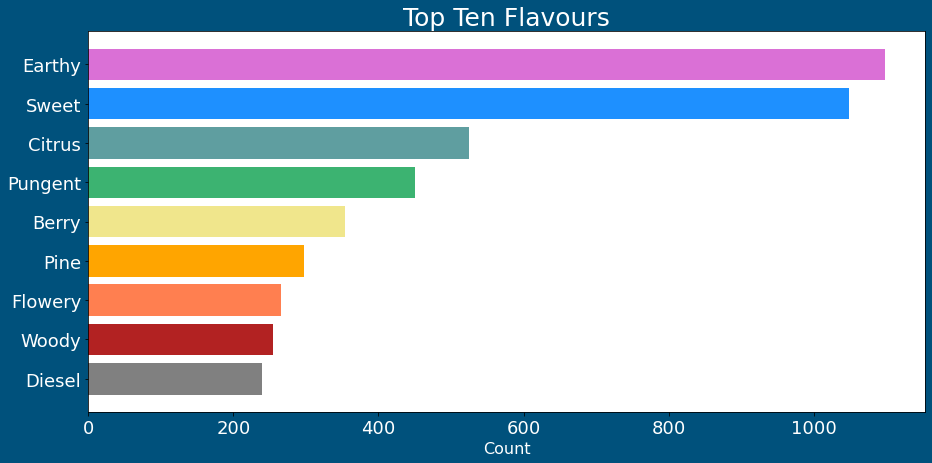

In [50]:
# plot the effects. 
colors = ['grey','firebrick','coral', 'orange','khaki','mediumseagreen', 'cadetblue', 'dodgerblue', 'orchid', 'crimson']
plt.figure(figsize=(15,7), facecolor='#00517cff')
plt.barh(x, y, color=colors)
plt.yticks(color='white', fontsize=18)
plt.xlabel('Count', fontsize=16, color='white')
plt.xticks(color='white', fontsize=18)
plt.title("Top Ten Flavours", fontsize=25, color='white')
plt.show()

#### Analysis - Effects & Flavors

There are two flavors that dominate across the strains being "earthy" and "sweet". The next top flavors were citrus, pungent and berry. 

Further analysis by plant type may yield different results. 

## Effects & Flavors by Plant Type

First I'm going to create a new dataframe of our effects grouped by plant type. 
From there I can split each plant type into its own variable with its respective effects count. 

I can use these variables to plot the top effects for each plant type (which will be below).

#### Effects

In [51]:
# create new dataframe effects_summary
e_summary = pd.DataFrame(effects_type_df.groupby('Plant Type').sum())
e_summary.drop(['Dry', 'Mouth', 'None'], axis=1, inplace=True)

In [52]:
e_summary = e_summary.transpose()

In [53]:
# reset the index so we can create new df with effect and plant
e_summary.reset_index(inplace=True)

In [54]:
# rename the old index to effect
e_summary.rename(columns={'index':'effect'}, inplace=True)

In [55]:
# check
e_summary

Plant Type,effect,hybrid,indica,sativa
0,Aroused,72,36,28
1,Creative,270,123,100
2,Energetic,242,109,102
3,Euphoric,718,413,258
4,Focused,209,114,86
5,Giggly,86,67,36
6,Happy,865,514,320
7,Hungry,153,87,56
8,Relaxed,820,503,270
9,Sleepy,285,220,89


In [56]:
# separate into hybrid, sativa, and indica effects
e_hybrid = e_summary[['effect','hybrid']]
e_sativa = e_summary[['effect','sativa']]
e_indica = e_summary[['effect','indica']]

In [57]:
# sort the values by ascending order 
e_hybrid = e_hybrid.sort_values(by='hybrid')
e_sativa = e_sativa.sort_values(by='sativa')
e_indica = e_indica.sort_values(by='indica')

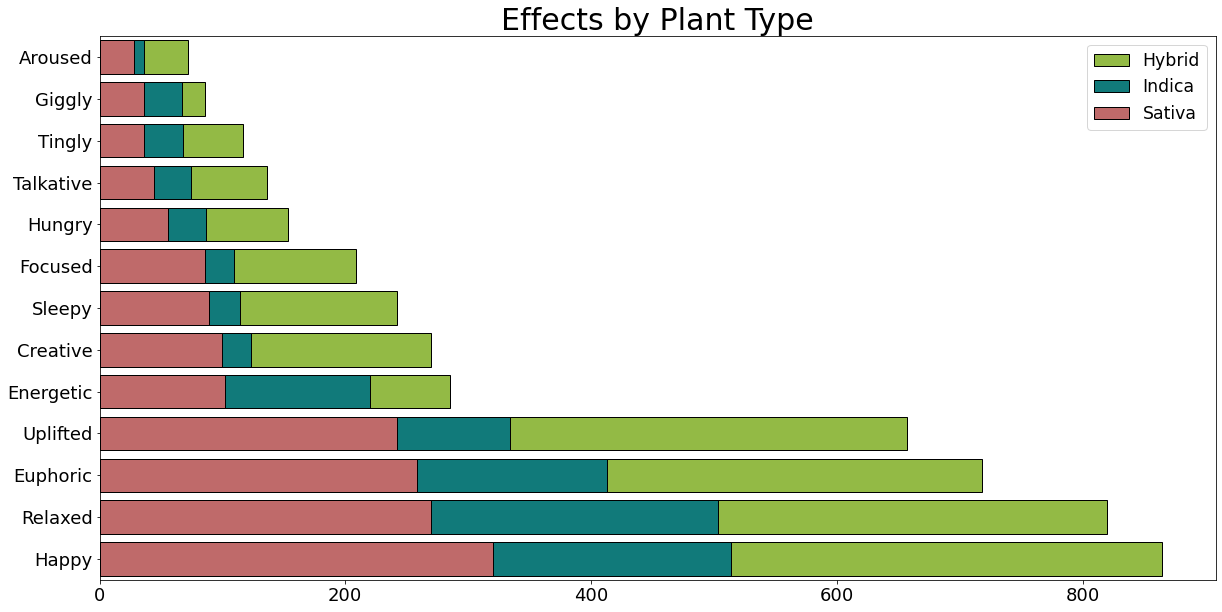

In [72]:
plt.figure(figsize=(20, 10))
sns.barplot(x="hybrid", y="effect", data=e_hybrid, color='yellowgreen', label='Hybrid', orient='h',edgecolor='black' )
sns.barplot(x="indica", y="effect", data=e_indica, color='darkcyan', label='Indica',orient='h', edgecolor='black')
sns.barplot(x="sativa", y='effect', data=e_sativa, color='indianred', label='Sativa',orient='h', edgecolor='black')
plt.ylabel(ylabel=None, size=18)
plt.yticks(size=18)
plt.xlabel(xlabel=None, size=18)
plt.xticks( size=18)
plt.title("Effects by Plant Type", fontsize=30)
plt.legend(fontsize='xx-large')
plt.show()

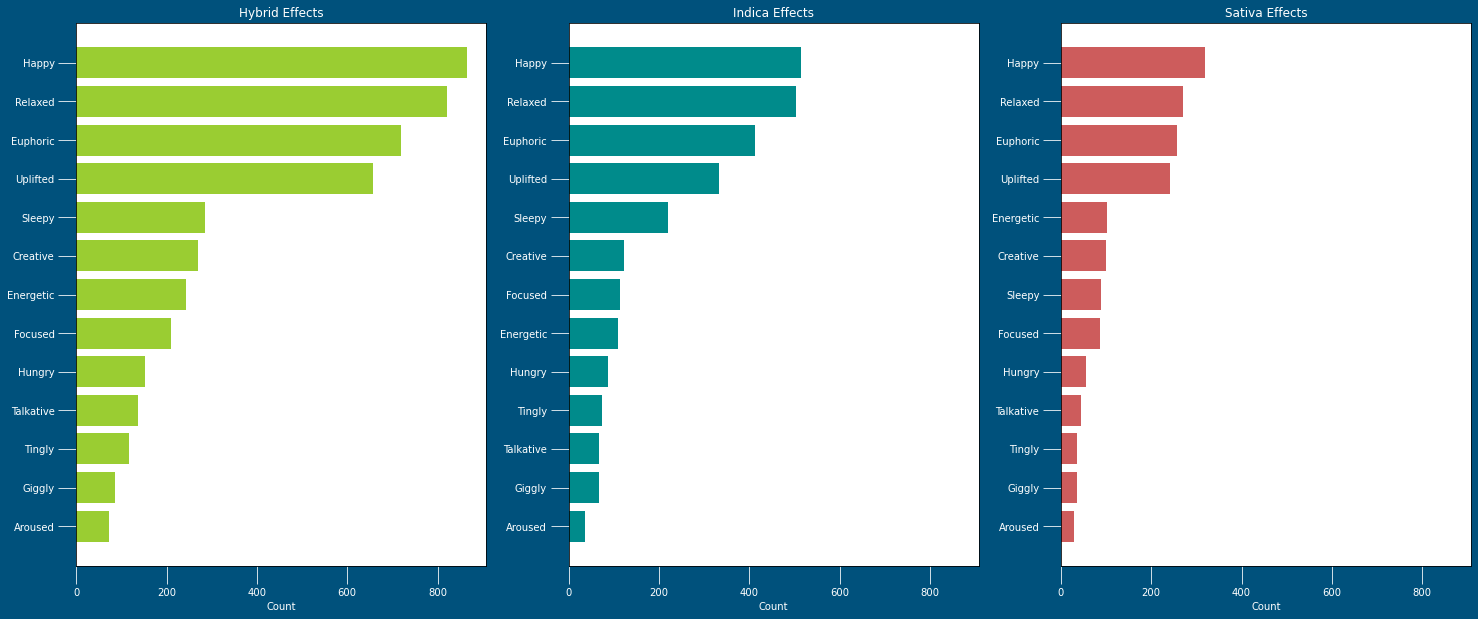

In [59]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, sharex=True, figsize=(25,10), facecolor='#00517cff')

ax1.tick_params(axis='both', colors='white', size=18)
ax1.barh(e_hybrid['effect'], e_hybrid['hybrid'], color='yellowgreen')
ax1.set_xlabel('Count', color='white')
ax1.set_title('Hybrid Effects', color='white')

ax2.tick_params(axis='both', colors='white', size=18)
ax2.barh(e_indica['effect'], e_indica['indica'], color='darkcyan')
ax2.set_xlabel('Count', color='white')
ax2.set_title('Indica Effects', color='white')

ax3.tick_params(axis='both', colors='white', size=18)
ax3.barh(e_sativa['effect'], e_sativa['sativa'], color='indianred')
ax3.set_xlabel('Count', color='white')
ax3.set_title('Sativa Effects', color='white')
plt.show()

#### Analysis - Effects by Plant Type

For the most part, each plant type has similar effects noted. But if we look beyond the top 4 effects, we can see that hybrid and indicas list 'sleepy' as the 5th effect while sativa has 'energetic' listed. Sativa strains are known to be better for daytime use because they are not as sleepy compared to indica and/or hyrbids. 

#### Flavors

In [60]:
f_summary = pd.DataFrame(flavors_type_df.groupby('Plant Type').sum())

f_summary = f_summary.transpose()

f_summary = f_summary.reset_index()

f_summary = f_summary.rename(columns={'index':'flavor'})

f_summary.drop(24, axis=0, inplace=True)

In [61]:
# pull out individual plant types and their respective flavor count.
f_hybrid = f_summary[['flavor', 'hybrid']]
f_indica = f_summary[['flavor', 'indica']]
f_sativa = f_summary[['flavor', 'sativa']]

In [62]:
# sort values and select the top 10 flavors for each type
f_hybrid = f_hybrid.sort_values(by='hybrid').tail(10)
f_indica = f_indica.sort_values(by='indica').tail(10)
f_sativa = f_sativa.sort_values(by='sativa').tail(10)

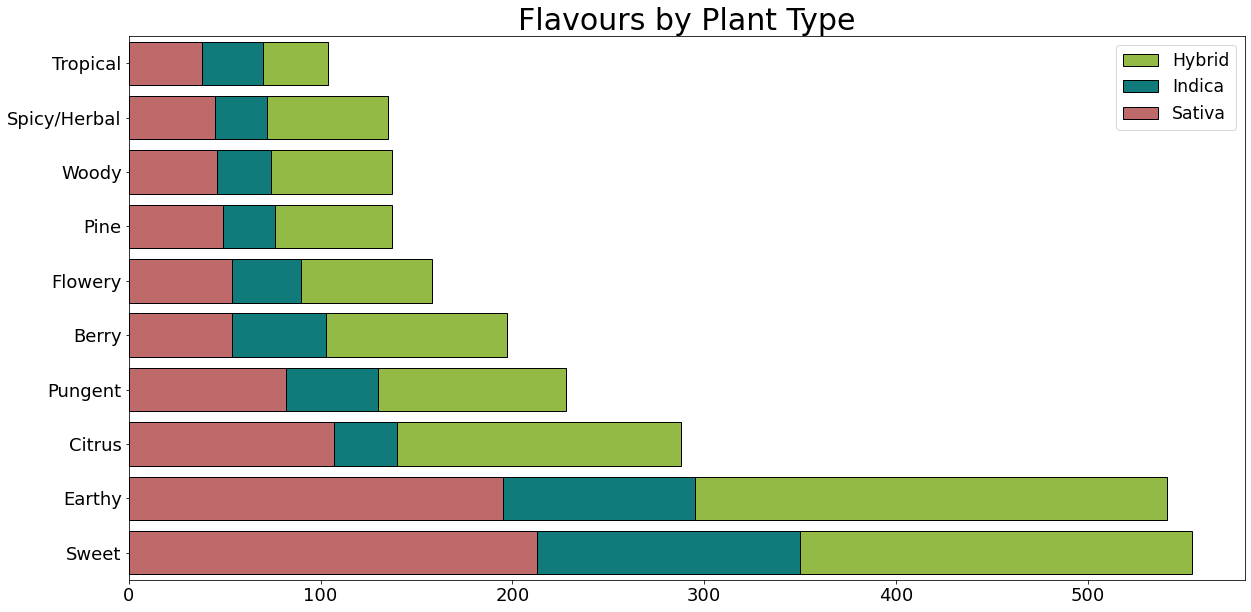

In [73]:
plt.figure(figsize=(20,10))
sns.barplot(x="hybrid", y="flavor", data=f_hybrid, color='yellowgreen', label='Hybrid', orient='h', edgecolor='black')
sns.barplot(x="indica", y="flavor", data=f_indica, color='darkcyan', label='Indica', orient='h', edgecolor='black')
sns.barplot(x="sativa", y='flavor', data=f_sativa, color='indianred', label='Sativa', orient='h', edgecolor='black')
plt.ylabel(ylabel=None)
plt.xlabel(xlabel=None, fontsize=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Flavours by Plant Type", fontsize=30)
plt.legend(fontsize='xx-large')
plt.show()

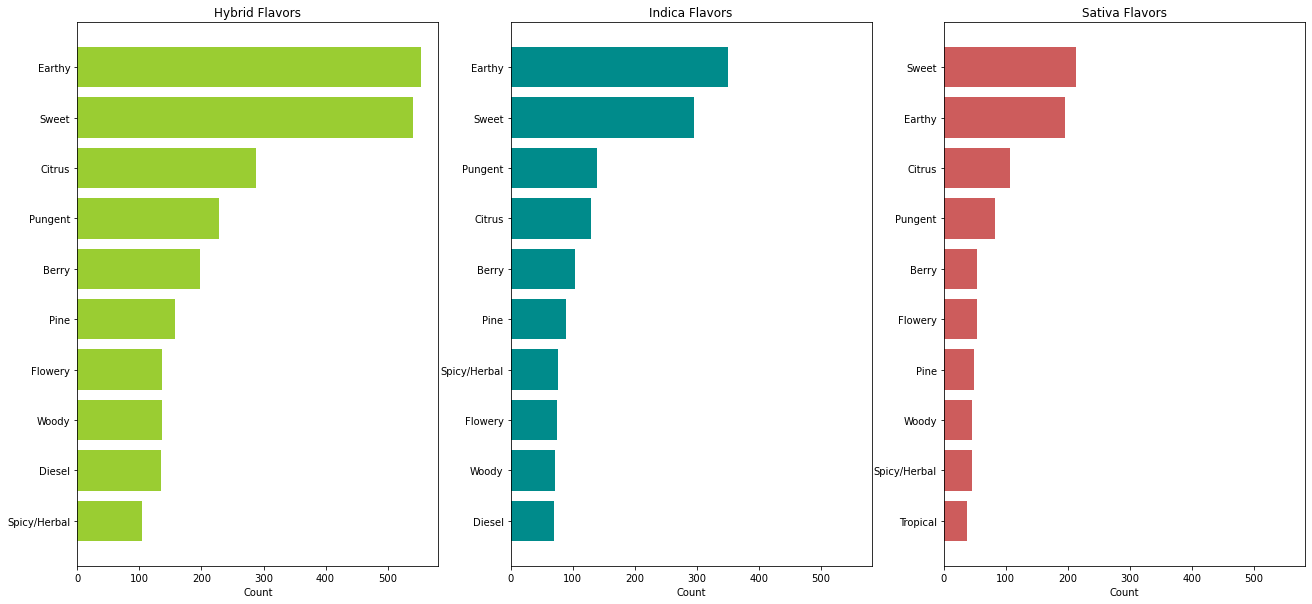

In [64]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, sharex=True, figsize=(22,10))

ax1.barh(f_hybrid['flavor'], f_hybrid['hybrid'], color='yellowgreen')
ax1.set_xlabel('Count')
ax1.set_title('Hybrid Flavors')

ax2.barh(f_indica['flavor'], f_indica['indica'], color='darkcyan')
ax2.set_xlabel('Count')
ax2.set_title('Indica Flavors')

ax3.barh(f_sativa['flavor'], f_sativa['sativa'], color='indianred')
ax3.set_xlabel('Count')
ax3.set_title('Sativa Flavors')
plt.show()

#### Analysis


The flavor profiles seem to be similar across all three plant types. Sativa strains are typically sweet and citrus flavored - limone (lemon flavor)

# Pre-Processing


I'm going to split my data before performing any transformations on the effects, flavors, type, and description. 

In [64]:
#save new dataframe to csv to work with on unsupervised models.
weed_df.to_csv('cannabis_clean.csv', index=False)

In [65]:
# First I'm going to copy my df into a new df incase of any issues
weed_df2 = weed_df.copy()

In [66]:
# drop the strain name, then set up x and ys
weed_df2.drop('Strain', axis=1, inplace=True)

# x and y variables
X = weed_df2.iloc[:, 1:]
y = weed_df2.iloc[:, 0]

Okay, I almost have my dataframe where it needs to be before I can begin to model. 

The remaining steps needed are: 
    - encode type column (0, 1, 2)
    - NLP (CountVectorizer) on the description column.
    
After these two steps, then I can split my dataset into X and y and further split into a X_train and X_test format. 

### Target Column

Now we'll encode the y_train target variable into integers. 
In alphabetical order:
hybrid = 0
indica = 1
sativa = 2

In pandas you can set a column datatype as a category and then have pandas convert the categories into unique integers. 

In [67]:
from sklearn.preprocessing import LabelEncoder

# instantiate the label encoder
le = LabelEncoder()

# fit and transform on the y column (plant type)
le.fit(y)

y = le.transform(y)

In [68]:
le.classes_

array(['hybrid', 'indica', 'sativa'], dtype=object)

### Modeling

#### Split the data

In [69]:
from sklearn.model_selection import train_test_split

# split our daata into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)

In [70]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (1574, 11)
y_train: (1574,)
X_test: (776, 11)
y_test: (776,)


Next I need to extract the flavors and effects columns so that I can do turn the strings into dummy variables on both the train and test sets.
I'm going to combine the train and test set to avoid having different column lengths after converting the data into dummy variables. 

In [71]:
train_num = len(X_train)
dataset = pd.concat(objs=[X_train, X_test], axis=0)
dataset2 = dataset.iloc[:,2:]
dataset2 = pd.get_dummies(dataset2)

In [72]:
train = dataset2.iloc[:1574,:]
test = dataset2.iloc[1574:, :]

In [73]:
X_train = X_train.iloc[:,:2]
X_test = X_test.iloc[:,:2]

In [74]:
# Merge train and test back to their original 

X_train = X_train.merge(train, how='inner', left_index=True, right_index=True)
X_test = X_test.merge(test, how='inner', left_index=True, right_index=True)

In [75]:
X_test.head()

,Rating,Description,Effect 1_Aroused,Effect 1_Creative,Effect 1_Dry,Effect 1_Energetic,Effect 1_Euphoric,Effect 1_Focused,Effect 1_Giggly,Effect 1_Happy,...,Flavor 4_Fruit,Flavor 4_Grape,Flavor 4_Lemon,Flavor 4_None,Flavor 4_Orange,Flavor 4_Pine,Flavor 4_Pineapple,Flavor 4_Pungent,Flavor 4_Spicy/Herbal,Flavor 4_Sweet
1396,4.4,When word got out that the Olympic gold medali...,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
669,4.2,Dirty Widow is a sativa-dominant hybrid loaded...,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2004,4.4,"By combining Chronic, White Widow, and Cheese,...",0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
809,4.4,Frankenstein is an 80% indica strain whose par...,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1905,4.0,"By combining the flavorful, high-yielding Snow...",1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [76]:
X_train.shape

(1574, 236)

In [77]:
X_test.shape

(776, 236)

#### NLP on Description Column
1. Count Vectorizer
2. Tfid Vectorizer

In [78]:
from sklearn.feature_extraction import text 
my_additional_stop_words = ('sativa', 'indica', 'hybrid', 'strain', 'strains', 'effects','dominant')
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

In [79]:
# 1. Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer

### Description Column

# Count Vectorizatio
from nltk.corpus import stopwords
# instantiate model
descriptionbag = CountVectorizer(stop_words=stop_words,\
                                 strip_accents='ascii',
                                 analyzer='word',
                                 )

# fit
descriptionbag.fit(X_train['Description'])

# transform
X_train_des = descriptionbag.transform(X_train['Description'])
X_test_des = descriptionbag.transform(X_test['Description'])

In [80]:
X_train_des = X_train_des.toarray()
X_test_des = X_test_des.toarray()

In [81]:
# create train and test dataframes
train_df = pd.DataFrame(data=X_train_des, columns=descriptionbag.get_feature_names())
test_df = pd.DataFrame(data=X_test_des, columns=descriptionbag.get_feature_names())

# reset the index of X_train and X_test
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# drop the description column in both sets.
X_train.drop('Description', axis=1, inplace=True)
X_test.drop('Description', axis=1, inplace=True)

# now we can join our NLP results with our X_train and X_test
X_train = X_train.join(train_df)
X_test = X_test.join(test_df)

In [82]:
word_counts = np.array(np.sum(X_train_des, axis=0))
words = np.array(descriptionbag.get_feature_names())

In [83]:
words_df = pd.DataFrame({"word":words, 
                         "count":word_counts})

In [84]:
words_df.sort_values(by="count", ascending=False).head(15).reset_index(drop=True)

,word,count
0,kush,718
1,og,656
2,aroma,599
3,sweet,569
4,cross,536
5,body,509
6,genetics,472
7,buds,415
8,high,400
9,purple,400


In [85]:
words_df = pd.DataFrame({"word":words, 
                         "count":word_counts})

In [86]:
len(words)

7426

### Modeling of CountVectorizer 

In [87]:
# import models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

#### Logistic Regression

In [88]:
# Instantiate supervised learning models
# set up empty accuracy lists
log_train_acc = []
log_test_acc = []

# set up C values
c_values = [0.000001,0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

for c in c_values:
    # instantiate model
    my_log = LogisticRegression(C=c, random_state=2, max_iter=500, n_jobs=-1)
    # fit the model on train set
    my_log.fit(X_train, y_train)
    # score the model and append results to list
    log_train_acc.append(my_log.score(X_train, y_train))
    log_test_acc.append(my_log.score(X_test, y_test)) 

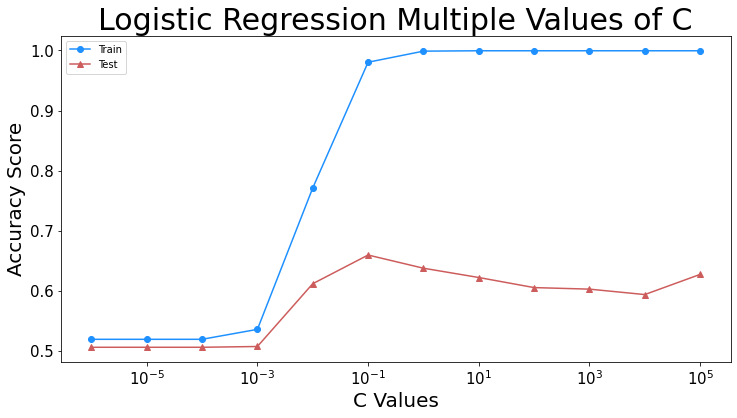

In [89]:
# visualize the results
plt.figure(figsize=(12,6))
plt.plot(c_values, log_train_acc, marker='o', color='dodgerblue', label='Train')
plt.plot(c_values, log_test_acc, marker='^', color='indianred', label='Test')
plt.xlabel('C Values', size=20)
plt.xticks(size=15)
plt.xscale('log')
plt.ylabel('Accuracy Score', size=20)
plt.yticks(size=15)
plt.title('Logistic Regression Multiple Values of C', size=30)
plt.legend()
plt.show()

#### KNeighborsClassifier

In [90]:
from sklearn.neighbors import KNeighborsClassifier

knn_train_acc, knn_test_acc = [], []

# set up range of neighbors
n_neighbors = np.arange(1,52,2)

for n in n_neighbors:
    # instantiate KNN models
    my_knn = KNeighborsClassifier(n_neighbors=n, n_jobs=-1)

    # fit the models
    my_knn.fit(X_train, y_train)
    
    # score and append to lists
    knn_train_acc.append(my_knn.score(X_train, y_train))
    knn_test_acc.append(my_knn.score(X_test, y_test))

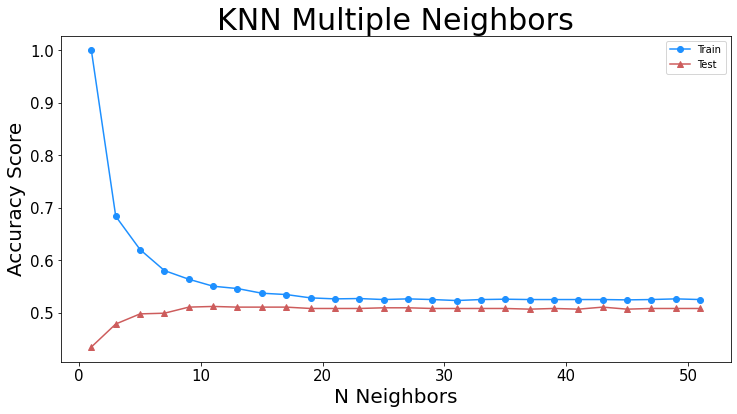

In [91]:
# visualize the results
plt.figure(figsize=(12,6))
plt.plot(n_neighbors, knn_train_acc, marker='o', color='dodgerblue', label='Train')
plt.plot(n_neighbors, knn_test_acc, marker='^', color='indianred', label='Test')
plt.xlabel('N Neighbors', size=20)
plt.xticks(size=15)
plt.ylabel('Accuracy Score', size=20)
plt.yticks(size=15)
plt.title('KNN Multiple Neighbors', size=30)
plt.legend()
plt.show()

#### SVM Model

In [92]:
from sklearn.svm import SVC
svm_train_acc, svm_test_acc = [], []

kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for k in kernels:
    # instantiate
    my_SVM = SVC(kernel=k)
    # Fit
    my_SVM.fit(X_train, y_train)
    # score and append
    svm_train_acc.append(my_SVM.score(X_train, y_train))
    svm_test_acc.append(my_SVM.score(X_test, y_test))

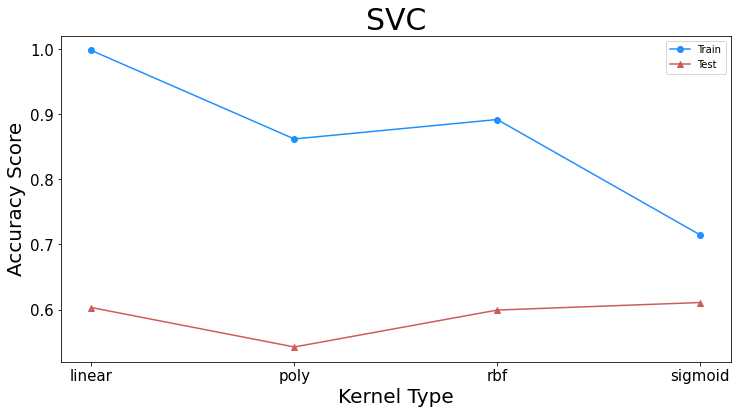

In [93]:
# visualize the results
plt.figure(figsize=(12,6))
plt.plot(kernels, svm_train_acc, marker='o', color='dodgerblue', label='Train')
plt.plot(kernels, svm_test_acc, marker='^', color='indianred', label='Test')
plt.xlabel('Kernel Type', size=20)
plt.xticks(size=15)
plt.ylabel('Accuracy Score', size=20)
plt.yticks(size=15)
plt.title('SVC', size=30)
plt.legend()
plt.show()

#### DecisionTree Classifier

In [94]:
from sklearn.tree import DecisionTreeClassifier

dt_train_acc, dt_test_acc = [], []

# create max_depth ranges
max_depths = np.arange(1,100,1)

# loop through different depths
for i in max_depths:
    
    # instantiate
    my_decisiontree = DecisionTreeClassifier(max_depth=i)
    
    # fit
    my_decisiontree.fit(X_train, y_train)
    
    # score
    dt_train_acc.append(my_decisiontree.score(X_train, y_train))
    dt_test_acc.append(my_decisiontree.score(X_test, y_test))

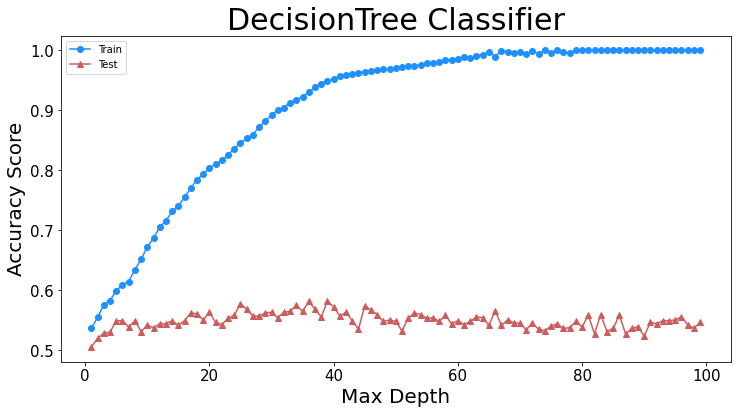

In [95]:
# visualize the results
plt.figure(figsize=(12,6))
plt.plot(max_depths, dt_train_acc, marker='o', color='dodgerblue', label='Train')
plt.plot(max_depths, dt_test_acc, marker='^', color='indianred', label='Test')
plt.xlabel('Max Depth', size=20)
plt.xticks(size=15)
plt.ylabel('Accuracy Score', size=20)
plt.yticks(size=15)
plt.title('DecisionTree Classifier', size=30)
plt.legend()
plt.show()

### TfidVectorizer

In [78]:
cannabis = pd.read_csv('cannabis_clean.csv')
cannabis.head()

,Strain,Type,Rating,Description,Effect 1,Effect 2,Effect 3,Effect 4,Effect 5,Flavor 1,Flavor 2,Flavor 3,Flavor 4
0,100-Og,hybrid,4.0,$100 OG is a 50/50 hybrid strain that packs a ...,Creative,Energetic,Tingly,Euphoric,Relaxed,Earthy,Sweet,Citrus,None
1,98-White-Widow,hybrid,4.7,The ‘98 Aloha White Widow is an especially pot...,Relaxed,Aroused,Creative,Happy,Energetic,Flowery,Violet,Diesel,None
2,1024,sativa,4.4,1024 is a sativa-dominant hybrid bred in Spain...,Uplifted,Happy,Relaxed,Energetic,Creative,Spicy/Herbal,Sage,Woody,None
3,13-Dawgs,hybrid,4.2,13 Dawgs is a hybrid of G13 and Chemdawg genet...,Tingly,Creative,Hungry,Relaxed,Uplifted,Apricot,Citrus,Grapefruit,None
4,24K-Gold,hybrid,4.6,"Also known as Kosher Tangie, 24k Gold is a 60%...",Happy,Relaxed,Euphoric,Uplifted,Talkative,Citrus,Earthy,Orange,None


In [79]:
cannabis.drop(['Strain', 'Rating'], axis=1, inplace=True)

In [80]:
cannabis.head()

,Type,Description,Effect 1,Effect 2,Effect 3,Effect 4,Effect 5,Flavor 1,Flavor 2,Flavor 3,Flavor 4
0,hybrid,$100 OG is a 50/50 hybrid strain that packs a ...,Creative,Energetic,Tingly,Euphoric,Relaxed,Earthy,Sweet,Citrus,None
1,hybrid,The ‘98 Aloha White Widow is an especially pot...,Relaxed,Aroused,Creative,Happy,Energetic,Flowery,Violet,Diesel,None
2,sativa,1024 is a sativa-dominant hybrid bred in Spain...,Uplifted,Happy,Relaxed,Energetic,Creative,Spicy/Herbal,Sage,Woody,None
3,hybrid,13 Dawgs is a hybrid of G13 and Chemdawg genet...,Tingly,Creative,Hungry,Relaxed,Uplifted,Apricot,Citrus,Grapefruit,None
4,hybrid,"Also known as Kosher Tangie, 24k Gold is a 60%...",Happy,Relaxed,Euphoric,Uplifted,Talkative,Citrus,Earthy,Orange,None


In [81]:
cannabis['Type'] = cannabis['Type'].astype('category').cat.codes

In [82]:
cannabis

,Type,Description,Effect 1,Effect 2,Effect 3,Effect 4,Effect 5,Flavor 1,Flavor 2,Flavor 3,Flavor 4
0,0,$100 OG is a 50/50 hybrid strain that packs a ...,Creative,Energetic,Tingly,Euphoric,Relaxed,Earthy,Sweet,Citrus,None
1,0,The ‘98 Aloha White Widow is an especially pot...,Relaxed,Aroused,Creative,Happy,Energetic,Flowery,Violet,Diesel,None
2,2,1024 is a sativa-dominant hybrid bred in Spain...,Uplifted,Happy,Relaxed,Energetic,Creative,Spicy/Herbal,Sage,Woody,None
3,0,13 Dawgs is a hybrid of G13 and Chemdawg genet...,Tingly,Creative,Hungry,Relaxed,Uplifted,Apricot,Citrus,Grapefruit,None
4,0,"Also known as Kosher Tangie, 24k Gold is a 60%...",Happy,Relaxed,Euphoric,Uplifted,Talkative,Citrus,Earthy,Orange,None
...,...,...,...,...,...,...,...,...,...,...,...
2345,0,Zeus OG is a hybrid cross between Pineapple OG...,Relaxed,Happy,Euphoric,Uplifted,Sleepy,Sweet,Berry,Grape,None
2346,1,Zkittlez is an indica-dominant mix of Grape Ap...,Relaxed,Sleepy,Talkative,Euphoric,Happy,Earthy,Sweet,Spicy/Herbal,None
2347,1,Zombie Kush by Ripper Seeds comes from two dif...,Relaxed,Sleepy,Euphoric,Happy,Hungry,Sweet,Earthy,Pungent,None
2348,1,If you’re looking to transform into a flesh-ea...,Hungry,Relaxed,Uplifted,Happy,Sleepy,Berry,Earthy,Pungent,None


In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X = cannabis.iloc[:,1]
y = cannabis['Type']

In [84]:
from sklearn.feature_extraction import text
my_additional_stop_words = ('sativa', 'cross', 'indica', 'hybrid', 'strain', 'strains', 'effects','dominant', 'none')
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

In [85]:
# using our custom tokenizer in CountVectorizer
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

tfidf = TfidfVectorizer(min_df=3, stop_words=stop_words, ngram_range = (1,4))
tfidf.fit(X_train)
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)

In [86]:
my_df = pd.DataFrame(columns=tfidf.get_feature_names(), data=X_train.toarray())
display(my_df)

,10,10 11,10 11 weeks,10 week,10 week flowering,10 week flowering time,10 weeks,100,11,11 weeks,...,yields dense,yields high,yields indoors,yields make,yields sweet,zest,zesty,zesty lemon,zion,zion botanicals
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
word_weights = np.array(np.sum(X_train, axis=0)).reshape((-1,))
words = np.array(tfidf.get_feature_names())
words_df = pd.DataFrame({"word":words, 
                         "weight":word_weights})
words_df.sort_values(by="weight", ascending=False).head(10)

,word,weight
3144,kush,43.785116
3964,og,42.718026
5531,sweet,30.928676
379,aroma,30.610845
4541,purple,29.722860
643,body,28.452240
2371,genetics,28.348807
2774,high,26.315293
2651,haze,25.735403
808,buds,24.971601


#### Logistic Regression 2

In [88]:
from sklearn.linear_model import LogisticRegression

# instantiate
my_log = LogisticRegression(n_jobs=-1, verbose=1)

# fit
my_log.fit(X_train, y_train)

# score
my_log.score(X_test, y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.2s finished


0.634020618556701

In [89]:
from sklearn.metrics import confusion_matrix

preds = my_log.predict(X_test)

con_mat = confusion_matrix(y_test,preds)

df_con_mat = pd.DataFrame(con_mat, columns = ['Predicted Hybrid','Predicted Indica','Predicted Sativa'],
                 index = ['True Hybrid','True Indica','True Sativa'])

df_con_mat

,Predicted Hybrid,Predicted Indica,Predicted Sativa
True Hybrid,347,42,4
True Indica,133,103,4
True Sativa,95,6,42


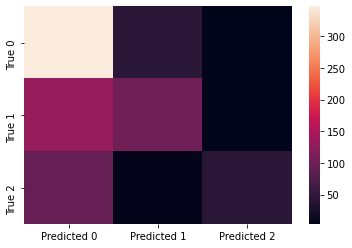

In [124]:
# heat map
sns.heatmap(df_con_mat)
plt.show()

In [109]:
# Instantiate supervised learning models
# set up empty accuracy lists
log2_train_acc = []
log2_test_acc = []

# set up C values
c_values = [0.000001,0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

for c in c_values:
    # instantiate model
    my_log_2 = LogisticRegression( C=c, random_state=2, max_iter=200)
    # fit the model on train set
    my_log_2.fit(X_train, y_train)
    # score the model and append results to list
    log2_train_acc.append(my_log_2.score(X_train, y_train))
    log2_test_acc.append(my_log_2.score(X_test, y_test)) 

/opt/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/envs/deeplearning/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

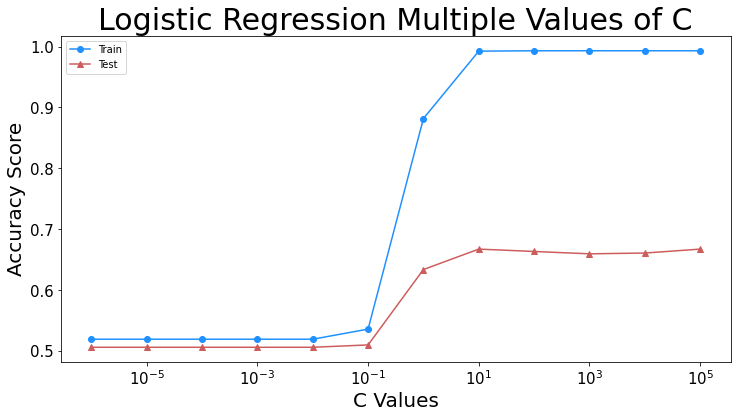

In [110]:
# visualize the results
plt.figure(figsize=(12,6))
plt.plot(c_values, log2_train_acc, marker='o', color='dodgerblue', label='Train')
plt.plot(c_values, log2_test_acc, marker='^', color='indianred', label='Test')
plt.xlabel('C Values', size=20)
plt.xticks(size=15)
plt.xscale('log')
plt.ylabel('Accuracy Score', size=20)
plt.yticks(size=15)
plt.title('Logistic Regression Multiple Values of C', size=30)
plt.legend()
plt.show()

#### KNN Model 2

In [111]:
from sklearn.neighbors import KNeighborsClassifier

knn2_train_acc, knn2_test_acc = [], []

# set up range of neighbors
n_neighbors = np.arange(1,52,2)

for n in n_neighbors:
    # instantiate KNN models
    my_knn_2 = KNeighborsClassifier(n_neighbors=n, n_jobs=-1)

    # fit the models
    my_knn_2.fit(X_train, y_train)
    
    # score and append to lists
    knn2_train_acc.append(my_knn_2.score(X_train, y_train))
    knn2_test_acc.append(my_knn_2.score(X_test, y_test))

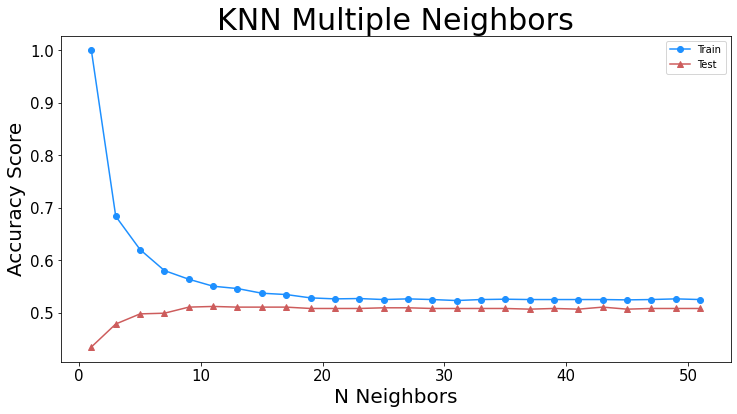

In [112]:
# visualize the results
plt.figure(figsize=(12,6))
plt.plot(n_neighbors, knn_train_acc, marker='o', color='dodgerblue', label='Train')
plt.plot(n_neighbors, knn_test_acc, marker='^', color='indianred', label='Test')
plt.xlabel('N Neighbors', size=20)
plt.xticks(size=15)
plt.ylabel('Accuracy Score', size=20)
plt.yticks(size=15)
plt.title('KNN Multiple Neighbors', size=30)
plt.legend()
plt.show()

#### SVM Model 2

In [113]:
from sklearn.svm import SVC
svm2_train_acc, svm2_test_acc = [], []

kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for k in kernels:
    # instantiate
    my_SVM_2 = SVC(kernel=k)
    # Fit
    my_SVM_2.fit(X_train, y_train)
    # score and append
    svm2_train_acc.append(my_SVM_2.score(X_train, y_train))
    svm2_test_acc.append(my_SVM_2.score(X_test, y_test))

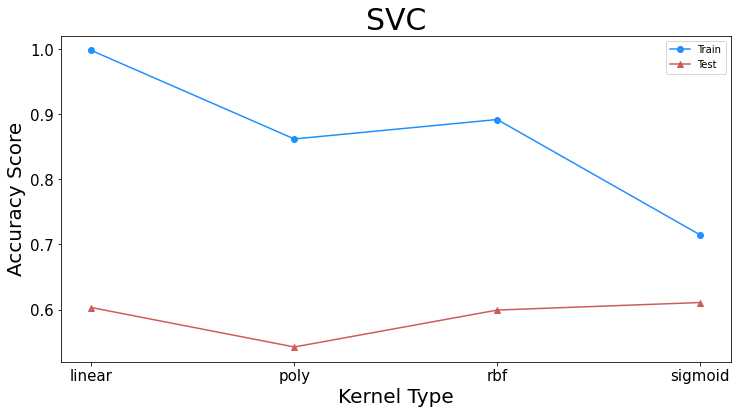

In [114]:
# visualize the results
plt.figure(figsize=(12,6))
plt.plot(kernels, svm_train_acc, marker='o', color='dodgerblue', label='Train')
plt.plot(kernels, svm_test_acc, marker='^', color='indianred', label='Test')
plt.xlabel('Kernel Type', size=20)
plt.xticks(size=15)
plt.ylabel('Accuracy Score', size=20)
plt.yticks(size=15)
plt.title('SVC', size=30)
plt.legend()
plt.show()

#### DecisionTree Classifier 2

In [115]:
from sklearn.tree import DecisionTreeClassifier

dt2_train_acc, dt2_test_acc = [], []

# create max_depth ranges
max_depths = np.arange(1,100,1)

# loop through different depths
for i in max_depths:
    
    # instantiate
    my_decisiontree_2 = DecisionTreeClassifier(max_depth=i)
    
    # fit
    my_decisiontree_2.fit(X_train, y_train)
    
    # score
    dt2_train_acc.append(my_decisiontree_2.score(X_train, y_train))
    dt2_test_acc.append(my_decisiontree_2.score(X_test, y_test))

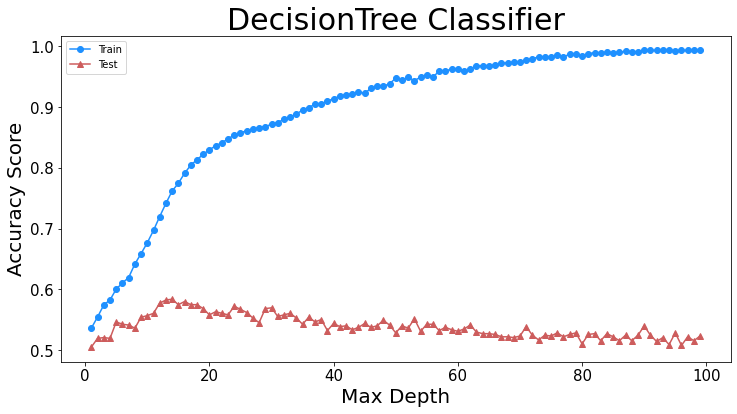

In [116]:
# visualize the results
plt.figure(figsize=(12,6))
plt.plot(max_depths, dt2_train_acc, marker='o', color='dodgerblue', label='Train')
plt.plot(max_depths, dt2_test_acc, marker='^', color='indianred', label='Test')
plt.xlabel('Max Depth', size=20)
plt.xticks(size=15)
plt.ylabel('Accuracy Score', size=20)
plt.yticks(size=15)
plt.title('DecisionTree Classifier', size=30)
plt.legend()
plt.show()

#### Analysis - CountVectorizer v TfidVectorizer

## Unsupervised - IDK

In [117]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [118]:
import tensorflow as tf
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))

b'Hello, TensorFlow!'


In [119]:
cannabis = pd.read_csv('cannabis_clean.csv')

In [120]:
can_df = cannabis.drop(['Strain', 'Description', 'Flavor 4'], axis=1)

In [121]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

encoded = ohe.fit_transform(X)
encoded

ValueError: Expected 2D array, got 1D array instead:
array=['$100 OG is a 50/50 hybrid strain that packs a strong punch. The name supposedly refers to both its strength and high price when it first started showing up in Hollywood. As a plant, $100 OG tends to produce large dark green buds with few stems. Users report a strong body effect of an indica for pain relief with the more alert, cerebral feeling thanks to its sativa side.'
 'The ‘98 Aloha White Widow is an especially potent cut of White Widow that has grown in renown alongside Hawaiian legends like Maui Wowie and Kona Gold. This White Widow phenotype reeks of diesel and skunk and has a rich earthy taste with intermittent notes of hash. Its buds are coated in trichomes, giving its dark foliage a lustrous glint to go along with its room-filling odor. This one-hitter-quitter uplifts the mind with mind-bending euphoria that materializes in the body as airy relaxation. ‘98 Aloha White Widow is available from Pua Mana 1st Hawaiian Pakalōlō Seed Bank. \xa0'
 '1024 is a sativa-dominant hybrid bred in Spain by Medical Seeds Co. The breeders claim to guard the secret genetics due to security reasons, but regardless of its genetic heritage, 1024 is a THC powerhouse with a sweet and spicy bouquet. Subtle fruit flavors mix with an herbal musk to produce uplifting sativa effects. One specific phenotype is noted for having a pungent odor that fills a room, similar to burning incense.'
 ...
 'Zombie Kush by Ripper Seeds comes from two different Kush genetics, resulting in hues of purple embedded within its trichome-laden foliage. Created by crossing Sideral (Lavender Kush x Amnesia) with Bubba Kush, Zombie Kush’s unique genetic lineage and complex terpene profile won it 1st Prize at the 2017 Napoli Secret Cup for Best Extract and 1st Prize Indica at the 2016 UCLA Cup. It has enjoyable and potent effects with a snappy indoor flowering time of 55-60 days.'
 'If you’re looking to transform into a flesh-eating monster, Zombie OG is not the choice for you. After a taste of this indica, the only thing you’ll be hungry for are the cold cuts in the fridge (though you may be too catatonic to get up and grab them). Heavy and lethargic, this cross between OG Kush and Blackberry has been a favorite among those suffering from muscle spasms and acute pain. Due to its strong sedative effects, don’t expect to have the energy to rampage the city. This strain is best used at nighttime, when you’re not expecting to do much of anything.'
 'Zoom Pie (also known as Zombie Pie) is a heavy indica-dominant strain that blends the potency of Blue Zombie\xa0with the flavor and color of\xa0Cherry Pie. This combination yields blue and purple foliage that reeks of tart cherries and pungent skunky fuel. It is known to stimulate appetite while imbuing the consumer with a heady euphoria (presumably from the recessive African landrace, Durban Poison, nestled in Cherry Pie). Enjoy this strain as a means to crush stress, physical discomfort, and depression. But be aware, this strain will apply sedative effects to the body when dosed heavily.\xa0This strain was bred by Tank aka gansettfinest of NICE LLC.\xa0'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
encoded_dense = encoded.toarray()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X = can_df.iloc[:,2:]
y = can_df['Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()


one_hot_encoder = encoder.fit(list(y_train))
y_train = one_hot_encoder.transform(y_train)
y_test = one_hot_encoder.transform(y_test)

In [ ]:
X_test

In [ ]:
X_train = hot_encoder.transform(X_train)

In [ ]:
X_test = hot_encoder.transform(X_test)

In [ ]:
epochs = 10000

# Each epoch is one pass through the data
for epoch in range(epochs):
    
    # Update the network.
    # feed_dict passes in the input for training
    # train linkes the session to the network
    sess2.run(train, feed_dict={input_X: X_train, input_y: y_train})
    
    if epoch % 500 == 0 :
        # Get the training loss
        training_loss = sess2.run(loss, feed_dict={input_X: X_train, input_y: y_train})
        
        score = sess2.run([acc, acc_op], feed_dict={input_X: X_train, input_y: y_train})
        print(f'Epoch: {epoch}, Loss: {training_loss:.3f}, Accuracy: {score[1]:.3f}')